# Zero Truncation Extrapolation

### Truncation methods
- `max_freq` effectively truncates small coefficients below (1/2)^`max_freq` on average over `thetas ∈ [-π, π]`
- `max_freq` counts number of sin and cos
- `max_weight`: truncation based on _Pauli weight_. We can truncate Pauli strings that have many non-Identity Paulis, which has been proven to be a valid truncation for random circuits, but it also works well in practice
- `max_sins`
- `min_abs_coeff`

### Functions (based on cpa.jl)

In [1]:
using PauliPropagation
using Plots
using Logging
using Statistics
using GLM
using DataFrames
using StatsModels
using LsqFit
using Distributions

include("zte_recap_1_functions.jl")

Plots.default(show = true)
gr()

Plots.GRBackend()

# I. ZTE on TFIM

In [2]:
function full_run(ansatz; min_abs_coeff = 0.0, observable = nothing, record = false, cdr_method = "end")
    """
    Perform the simulations.
    """
    @logmsg SubInfo "ready to ruuuuuummmble"

    if observable==nothing || observable == obs_interaction(ansatz)
        observable = obs_interaction(ansatz)
        obs_string = "ZZ"
    elseif observable == obs_magnetization(ansatz)
        obs_string = "Z"
    end

    time1 = time()
    exact_expval_target = trotter_time_evolution(ansatz; observable = observable, min_abs_coeff = min_abs_coeff_target, record = record) #should be close to one as we stay in FM phase
    timetmp1 = time()
    @logmsg SubInfo "exact_expval_target done in $(round(timetmp1-time1; digits = 2)) s"

    noisy_expval_target = trotter_time_evolution(ansatz; observable = observable, min_abs_coeff = min_abs_coeff_target, record = record)
    timetmp2 = time()
    @logmsg SubInfo "noisy_expval_target done in $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2

    return exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after
end

#
function discard(array, threshold)
    """
    Discard the last part of the array if the relative difference between two consecutive elements is larger than threshold.
    Used to "detect" the "phase transition", distinguishing completly wrong result because of too much truncation
    from an approximate relevant result.
    """
    for i=1:length(array)-1
        if abs(array[i]-array[i+1])/abs(array[i])>threshold
            return array[1:i]            
        end
    end
    return array
end



discard (generic function with 1 method)

In [3]:


function expvals_trunc_levels(ansatz, trunc_type; trunc1=-6, trunc2=-1, threshold=0.01, n=50, gamma=0.01)
    """
    Runs simulations with a certain type of truncation at different levels.
    Arguments:
    - ansatz (trotter_ansatz_tfim struct): specify the parameters of the physical system of interest.
    - trunc_type (Symbol): specify the type of truncation.
    - trunc1 (int): specify the lowest level of truncation. If the truncation level is not an integer 
        (e.g. min_abs_coeff), it will be converted to 10^trunc1.
    - trunc2 (int): specify the highest level of truncation. If the truncation level is not an integer 
        (e.g. min_abs_coeff), it will be converted to 10^trunc2.
    - threshold (float): used in the function discard to detect the "phase transition" and decide which points
        are included in the fit.
    - n (int): number of truncation levels to try out.
    - gamma (float): I forgot. Joking. Iirc used in some personalized truncations.
    """
    if trunc_type==:min_abs_coeff || trunc_type==:truncatedampingcoeff || trunc_type==:truncateprobabilistically
        #trunc1 is lower bound, trunc2 is upper bound of min_abs_coeff truncation
        # n is the number of points in intervall, threshold is for the discard criteria 
        exponents = range(trunc1, trunc2, n)
        trunc_coeffs = 10.0 .^exponents
    else
        trunc_coeffs = trunc1:-1:trunc2
    end
    expvals = Vector{Float64}()   
    for trunc_value in trunc_coeffs
        if trunc_type==:truncatedampingcoeff 
            truncategamma = (pstr, coeff) -> truncatedampingcoeff(
                pstr, coeff, gamma, trunc_value
            )
            kwargs = (; customtruncfunc=truncategamma)
        elseif trunc_type==:truncateprobabilistically 
            # a logger to check how this mess works
            log = open("log_trunc.out", "a")
            truncategamma = (pstr, coeff) -> truncateprobabilistically(
                pstr, coeff, gamma, trunc_value, log
            )
            kwargs = (; customtruncfunc=truncategamma)
        else
            kwargs = (; trunc_type => trunc_value)
        end
        expval_t = trotter_time_evolution(ansatz; kwargs...)
        push!(expvals, expval_t)
    end
    clean_expvals = discard(expvals, threshold)
    clean_trunc_coeffs = trunc_coeffs[1:length(clean_expvals)]

    return clean_trunc_coeffs, clean_expvals, trunc_coeffs, expvals
end



function correcting_single_truncations(ansatz, trunc_type::Vector{Symbol}=[:min_abs_coeff]; 
    trunc1=[-6], trunc2=[-1], threshold=0.001, abs_threshold=1e-6, plotting=false, n=50, gamma=0.01, mode="fit")
    """
    Performs the simulations (calling expvals_trunc_levels) and correct the value. Can do some fancy plotting.
    Can either fit exponentially or linearly the data (mode="exp" or "lin") or average (mode="avg").
    """
    corrected_expvals = Dict()
    clean_trunc_coeffs = Dict()
    clean_expvals = Dict()
    trunc_coeffs = Dict()
    expvals = Dict()
    exact_expval = trotter_time_evolution(ansatz; record = false)

    for (t, t1, t2) in zip(trunc_type, trunc1, trunc2)
        # println("$t $t1 $t2")
        clean_trunc_coeffs_tmp, clean_expvals_tmp, trunc_coeffs_tmp, expvals_tmp = 
            expvals_trunc_levels(ansatz, t; trunc1=t1, trunc2=t2, threshold=threshold, n=n, gamma=gamma)
        
        # println(length(clean_expvals_tmp))
        # new filter: remove expvals below abs_threshold
        mask = clean_expvals_tmp .>= abs_threshold
        xdata = clean_trunc_coeffs_tmp[mask]
        ydata = clean_expvals_tmp[mask]

        if mode=="exp"
            model = (x, p)->p[1] .+ p[2] .* exp.(-p[3] .* x)
            p0 = [ydata[end], ydata[1] - ydata[end], 1.0]
            fit = curve_fit(model, xdata, ydata, p0)
            corrected_expval = model(0.0, fit.param)
        elseif mode=="lin"
            model = (x, p)-> p[1] .+ p[2] .* x
            p0 = [ydata[end], (ydata[end]-ydata[1])] #/max(xdata[end]-xdata[1], 1e-10)]
            fit = curve_fit(model, xdata, ydata, p0)
            corrected_expval = model(0.0, fit.param)
        elseif mode=="avg"
            corrected_expval = mean(ydata)
        else
            println("what's the heck is mode=$mode???? I average instead.")
            corrected_expval = mean(ydata)
        end
        # println("fit done")

        corrected_expvals[t] = corrected_expval
        trunc_coeffs[t] = trunc_coeffs_tmp
        clean_trunc_coeffs[t] = xdata
        clean_expvals[t] = ydata
        expvals[t] = expvals_tmp
        # println("assignments ok")
        
        rel_error_all = (expvals_tmp .- exact_expval) ./ exact_expval
        rel_error_all[rel_error_all .== 0] .= 1e-16
        rel_error_clean = (ydata .- exact_expval) ./ exact_expval
        rel_error_clean[rel_error_clean .== 0] .= 1e-16
        println(t, " :")
        # display with only 2 digits after the point
        println("exact_expval: ", exact_expval) #only print 2 digits after point
        println("corrected_expval: ", corrected_expval)

        println(format("relative error corrected: {:.2e}", abs(exact_expval - corrected_expval) / exact_expval))
        println(format("relative error of lowest truncation included: {:.2e}", abs(exact_expval - clean_expvals_tmp[1]) / exact_expval))
        if plotting
            expvals_tmp[expvals_tmp .== 0] .= 1e-16
            ydata[ydata .== 0] .= 1e-16

            p = plot(trunc_coeffs_tmp, expvals_tmp, markershape=:circle, label="Data not included\nin the fit", legend=:right)#, yscale=:log10)
            scatter!(xdata, ydata, markershape=:circle, label="Data included\nin the fit")
            #plot!(xdata, model.(xdata, Ref(fit.param)), label="ZTE fit", lw=2, ls=:dash)
            xfit = range(minimum(xdata), maximum(xdata), length=200)
            if mode=="lin" || mode=="exp"
                plot!(xfit, model.(xfit, Ref(fit.param)), label="ZTE fit $mode", lw=3, ls=:dash)
            else
                plot!(xfit, ones(200)*corrected_expval, line=:dash, lw=3, label="Averaged value")
            end

            xlabel!("truncation")
            ylabel!("expectation value")
            title!("$(String(t)) (fit $mode)")
            plot!(p, yscale=:log10)
            if t == :min_abs_coeff || t == :truncatedampingcoeff || t == :truncateprobabilistically
                plot!(p, xscale=:log10)
            end
            display(p)
        end
    end

    return corrected_expvals, clean_trunc_coeffs, clean_expvals, trunc_coeffs, expvals
end


correcting_single_truncations (generic function with 2 methods)

We first try out to perform ZTE naively on the final step of the evolution of a small TFIM system. We tried out exponential and linear fits, as well as simply averaging.

min_abs_coeff :
exact_expval: 0.7822457044270305
corrected_expval: 0.7809384257540828
relative error corrected: 1.67e-03
relative error of lowest truncation included: 3.24e-04
max_weight :
exact_expval: 0.7822457044270305
corrected_expval: 0.7799479554728513
relative error corrected: 2.94e-03
relative error of lowest truncation included: 0.00e+00
max_freq :
exact_expval: 0.7822457044270305
corrected_expval: 0.7758356349135558
relative error corrected: 8.19e-03
relative error of lowest truncation included: 0.00e+00
max_sins :
exact_expval: 0.7822457044270305
corrected_expval: 0.7793944521206437
relative error corrected: 3.64e-03
relative error of lowest truncation included: 8.23e-15


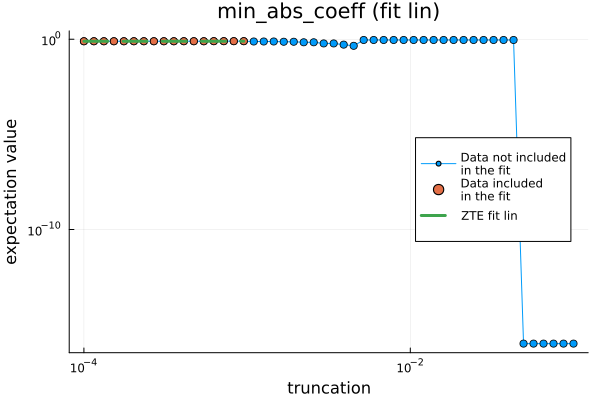

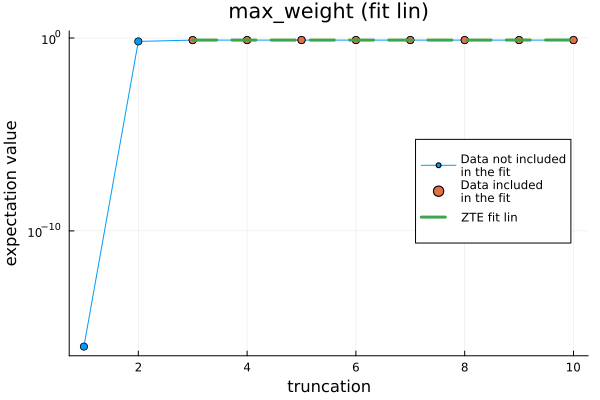

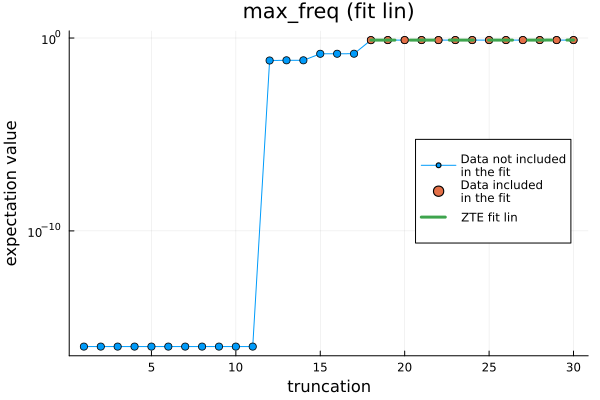

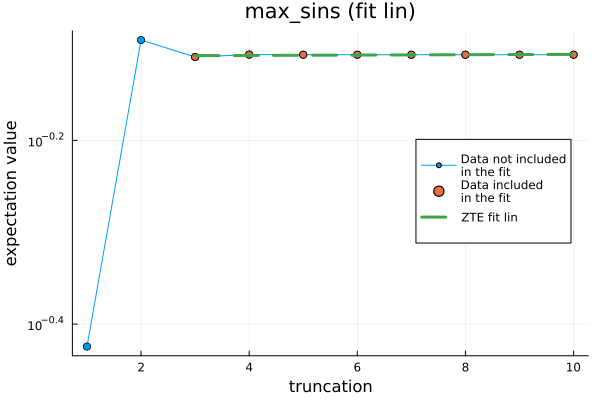

In [4]:
nq = 20
steps = 9
T = steps/20
J = 2.0
h = 1.0

trotter = trotter_setup(nq, steps, T, J, h);

correcting_single_truncations(trotter, [:min_abs_coeff, :max_weight, :max_freq, :max_sins]; trunc1=[-4, 10, 30, 10], trunc2=[-1, 1, 1, 1], threshold = 1e-2, plotting=true, mode="lin");


min_abs_coeff :
exact_expval: 0.7822457044270305
corrected_expval: 0.7809374808626695
relative error corrected: 1.67e-03
relative error of lowest truncation included: 3.24e-04
max_weight :
exact_expval: 0.7822457044270305
corrected_expval: -44367.516761331666
relative error corrected: 5.67e+04
relative error of lowest truncation included: 0.00e+00
max_freq :
exact_expval: 0.7822457044270305
corrected_expval: -1.5128729991584356e9
relative error corrected: 1.93e+09
relative error of lowest truncation included: 0.00e+00
max_sins :
exact_expval: 0.7822457044270305
corrected_expval: -3.2710571949715153e6
relative error corrected: 4.18e+06
relative error of lowest truncation included: 8.23e-15


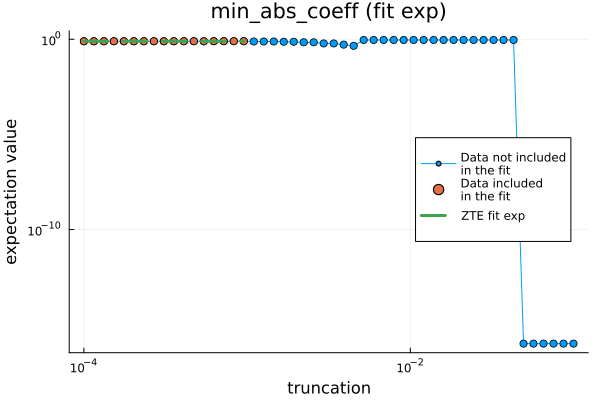

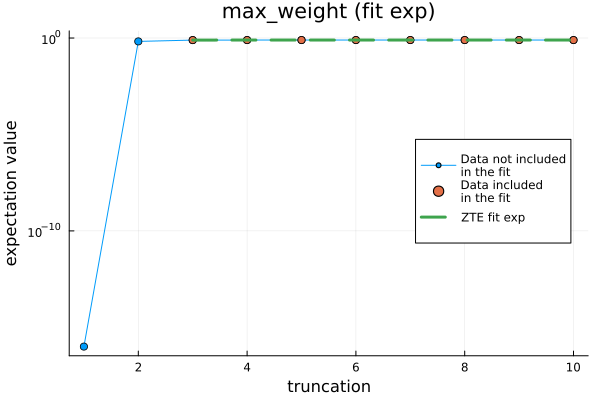

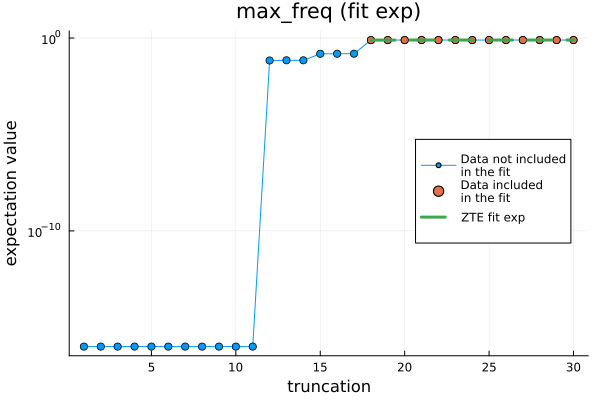

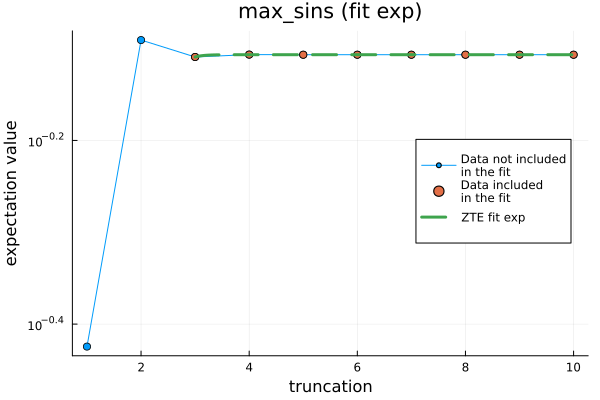

In [5]:

correcting_single_truncations(trotter, [:min_abs_coeff, :max_weight, :max_freq, :max_sins]; trunc1=[-4, 10, 30, 10], trunc2=[-1, 1, 1, 1], threshold = 1e-2, plotting=true, mode="exp");


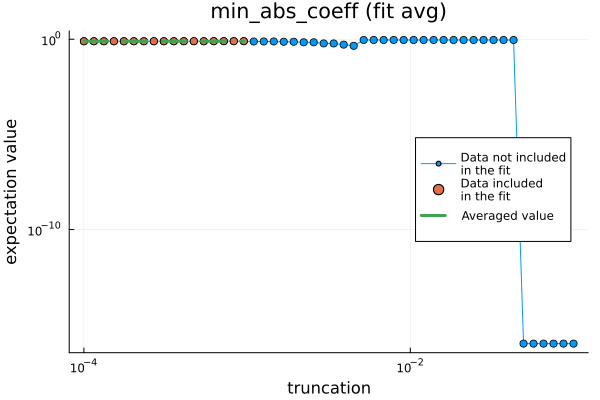

min_abs_coeff :
exact_expval: 0.7822457044270305
corrected_expval: 0.7843978382586794
relative error corrected: 2.75e-03
relative error of lowest truncation included: 3.24e-04
max_weight :
exact_expval: 0.7822457044270305
corrected_expval: 0.7818145889643989
relative error corrected: 5.51e-04
relative error of lowest truncation included: 0.00e+00
max_freq :
exact_expval: 0.7822457044270305
corrected_expval: 0.7816777235839164
relative error corrected: 7.26e-04
relative error of lowest truncation included: 0.00e+00
max_sins :
exact_expval: 0.7822457044270305
corrected_expval: 0.7817172372999321
relative error corrected: 6.76e-04
relative error of lowest truncation included: 8.23e-15


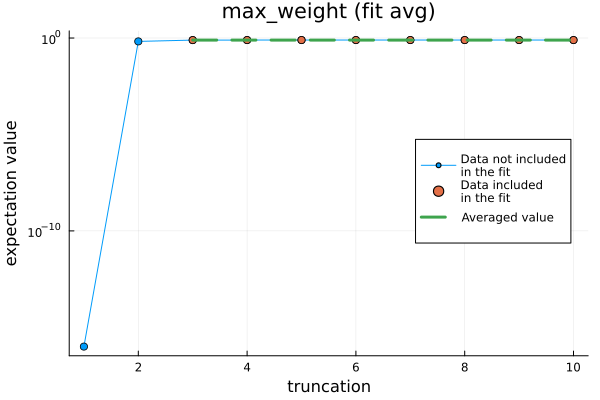

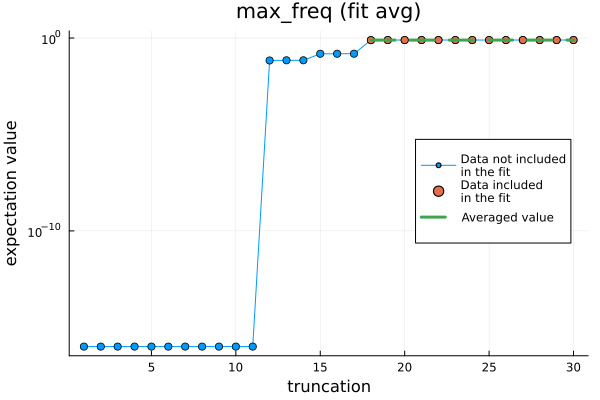

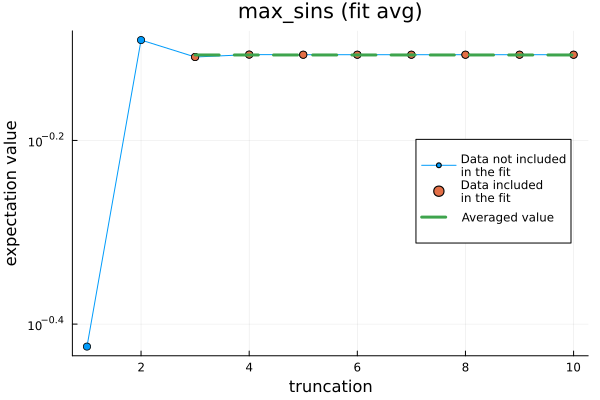

In [6]:

correcting_single_truncations(trotter, [:min_abs_coeff, :max_weight, :max_freq, :max_sins]; trunc1=[-4, 10, 30, 10], trunc2=[-1, 1, 1, 1], threshold = 1e-2, plotting=true, mode="avg");


No matter the "fitting" technique used the corrected value is always worse than the most precise value computed.
ZTE using min_abs_coeff truncation is the most promising one, giving a corrected value only 1 OoM less precised than the most precise value computed. The difference compared to the others truncations scheme is the "smoothness" of the transition from a regime where the expectation value is completly wrong to a good approximation regime.

Starting from this observation, we tried 2 different things:
- combining truncation to fit a hyperplane instead of a line
- trying what should be "smooth" truncations: probabilistic truncation and a truncation exponentially damped by the weight of the Pauli strings

The first option was a dismal failure. We explored a bit the second one.



In [7]:
function truncateprobabilistically(
    pstr::PauliStringType, coeff, theta::Real, min_abs_coeff::Real, log
)
    """
    If the coefficient is absolutely smaller than the min_abs_coeff, we compare it to a random number drawn format
    an exponential distribution. If it is smaller, we discard it (i.e. truncate the term).
    This function comes with a fancy (but performance killer) logging system (if you uncomment the write line)
    to see how many truncations are performed and fine tuned the parameter (debugging purposes only ofc).
    """
    coeff_abs = abs(tonumber(coeff))
    rnd = rand(Exponential(min_abs_coeff*theta))
    if coeff_abs>=min_abs_coeff
        ans = false
    elseif coeff_abs>=min(rnd, 1.0)
        ans = false
    else
        ans = true
    end
    str = format("{:.2e} {:.2e} {:.2e} {:.2e} {}\n", min_abs_coeff, min_abs_coeff*theta, coeff_abs, rnd, ans)
    # write(log, str)
    return ans
end

truncateprobabilistically (generic function with 1 method)

truncateprobabilistically :
exact_expval: 0.7822457044270305
corrected_expval: 0.7823913205949822
relative error corrected: 1.86e-04
relative error of lowest truncation included: 2.60e-06
truncateprobabilistically :
exact_expval: 0.7822457044270305
corrected_expval: 0.7825961250748672
relative error corrected: 4.48e-04
relative error of lowest truncation included: 2.44e-06
truncateprobabilistically :
exact_expval: 0.7822457044270305
corrected_expval: 0.7827962567468988
relative error corrected: 7.04e-04
relative error of lowest truncation included: 2.93e-06


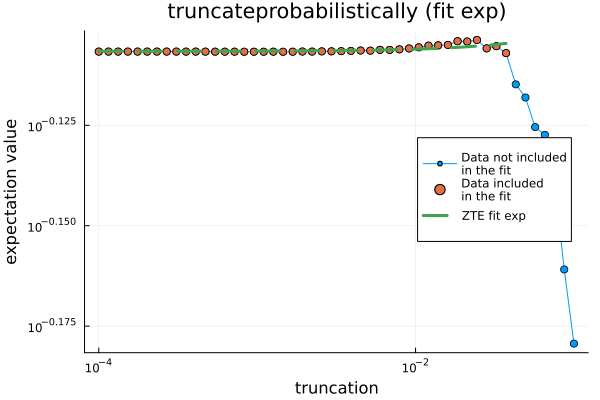

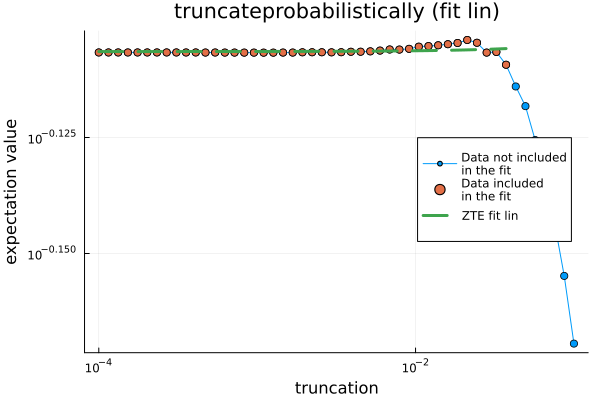

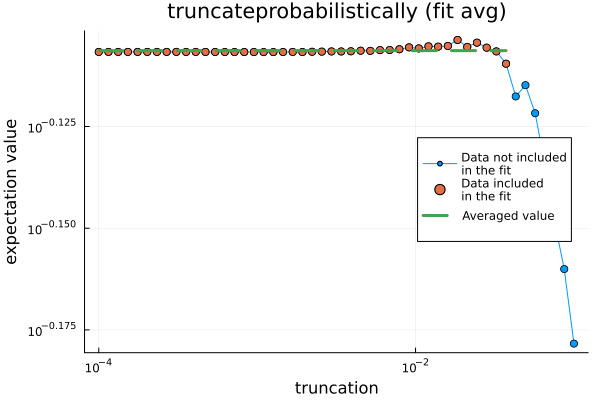

In [8]:

correcting_single_truncations(trotter, [:truncateprobabilistically]; trunc1=[-4], trunc2=[-1], threshold = 1e-2, plotting=true, mode="exp");
correcting_single_truncations(trotter, [:truncateprobabilistically]; trunc1=[-4], trunc2=[-1], threshold = 1e-2, plotting=true, mode="lin");
correcting_single_truncations(trotter, [:truncateprobabilistically]; trunc1=[-4], trunc2=[-1], threshold = 1e-2, plotting=true, mode="avg");


truncatedampingcoeff :
exact_expval: 0.7822457044270305
corrected_expval: 0.7807744939780259
relative error corrected: 1.88e-03
relative error of lowest truncation included: 5.98e-04
truncatedampingcoeff :
exact_expval: 0.7822457044270305
corrected_expval: 0.7811591279429205
relative error corrected: 1.39e-03
relative error of lowest truncation included: 5.98e-04
truncatedampingcoeff :
exact_expval: 0.7822457044270305
corrected_expval: 0.7845260945436399
relative error corrected: 2.92e-03
relative error of lowest truncation included: 5.98e-04


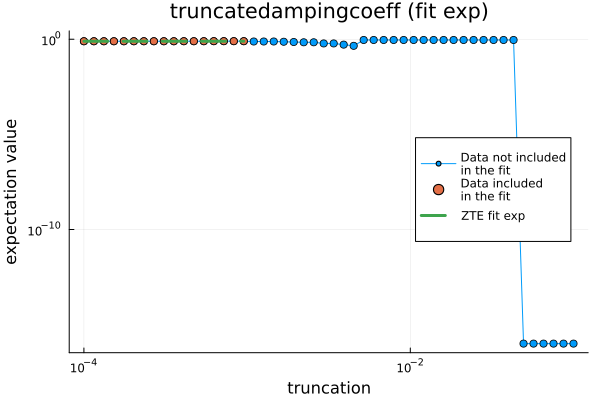

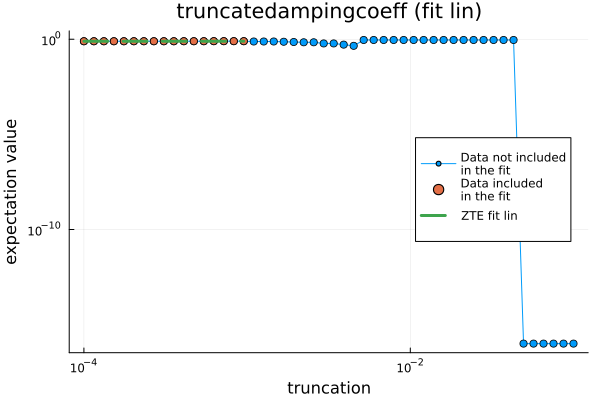

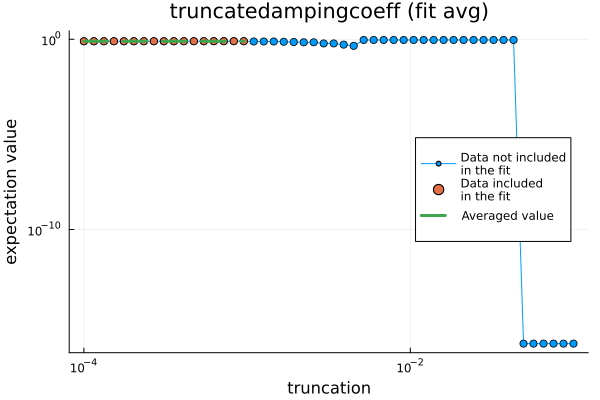

In [9]:

correcting_single_truncations(trotter, [:truncatedampingcoeff]; trunc1=[-4], trunc2=[-1], threshold = 1e-2, plotting=true, mode="exp");
correcting_single_truncations(trotter, [:truncatedampingcoeff]; trunc1=[-4], trunc2=[-1], threshold = 1e-2, plotting=true, mode="lin");
correcting_single_truncations(trotter, [:truncatedampingcoeff]; trunc1=[-4], trunc2=[-1], threshold = 1e-2, plotting=true, mode="avg");


It is not that satisfying...

# II. ZTE on imaginary time evolution data
Instead of questioning our approach, we decided to try it on another data. We used the data from Andrew who performed imaginary time evolution on different physical systems.

In [10]:
function run_or_read(model, circuit, nq, nl, tstep, obs_i, obs_j, max_weight, min_abs_coeff; run=false)
    """
    It's in the title. Run the simulation or use existing data if present. 
    """
    fn = format("data/{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}_minabscoeff={:.4e}.dat", model, nq, nl, tstep, obs_i, obs_j, max_weight, min_abs_coeff)
    expectation = 0
    observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j]);
    time = range(tstep, tstep*nl, nl)
    try
        @assert run==false
        open(fn, "r") do log
            data = CSV.read(log, DataFrame)
            time_file = data[!,1]
            expectation = data[!,2]
        end
    catch e
        expectation = thermalStateExpectation(circuit, nl, nq, observable; min_abs_coeff=min_abs_coeff, max_weight=max_weight)
        data = DataFrame(time=time, expectation=expectation)
        CSV.write(fn, data)
    end
    return expectation
end

run_or_read (generic function with 1 method)

In [11]:
# for some reason I recoded some new functions, we'll do something cleaner if needed
function zte_exp(expvals, truncs, times; plotting=true, exact_expvals=nothing, abs_threshold=1e-16, fn="")
    try
        @assert length(expvals)==length(truncs)
    catch e
        error("The length of input arguments don't match (length(expvals)=$(length(expvals)), length(truncs)=$(length(truncs)))")
    end
    corrected_expvals = Vector{Float64}()
    for idx=1:length(expvals[1])
        expvals_t = [row[idx] for row in expvals]
        # data = DataFrame(trunc=truncs, expval=expvals_t)
        push!(corrected_expvals, exp_fit(truncs, expvals_t; abs_threshold=abs_threshold, fn="plot_fits/"*fn*"_step=$idx.png"))
    end
    if plotting
        truncated_most_precise = expvals[end]
        try
            @assert length(times)==length(corrected_expvals)==length(truncated_most_precise)
        catch e
            error("The lengths don't match for plotting (length(times)=$(length(times)), length(corrected_expvals)=$(length(corrected_expvals)))")
        end
        corrected_expvals_cleaned = replace_zeros(corrected_expvals)
        truncated_most_precise_cleaned = replace_zeros(truncated_most_precise)
        p = plot(times, corrected_expvals_cleaned, label="corrected", marker=:circle)
        plot!(times, truncated_most_precise_cleaned, label="truncated most precise", marker=:circle)
        # plot!(yscale=:log10)
        xlabel!("Time")
        ylabel!("Observable")
        title!("Evolution over time")
        if exact_expvals!=nothing
            exact_expvals_cleaned = replace_zeros(exact_expvals)
            # plot!(times, exact_expvals_cleaned, label="exact", marker=:circle)
            rel_err_corr = replace_zeros(abs.((corrected_expvals-exact_expvals)./exact_expvals))
            q = plot(times, rel_err_corr, label="corrected", marker=:circle)
            rel_err_most_prec = replace_zeros(abs.((truncated_most_precise-exact_expvals)./exact_expvals))
            plot!(times, rel_err_most_prec, label="truncated most precise", marker=:circle)
            plot!(yscale=:log10)
            xlabel!("Timestep")
            ylabel!("Relative error")
            title!("Evolution over time")
            display(q)
        end
        display(p)
    end
    return corrected_expvals
end

function exp_fit(xdata, ydata; abs_threshold=1e-16, fn="")
    mask = xdata .>= abs_threshold
    xdata = xdata[mask]
    ydata = ydata[mask]
    model(x, p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
    p0 = [ydata[end], ydata[1] - ydata[end], 1.0]
    fit = curve_fit(model, xdata, ydata, p0)

    if fn!=""
        scatter(xdata, ydata, label="data", marker=:circle)
        plot!(xdata, model(xdata, fit.param), label="fit")
        if minimum(xdata)<1
            plot!(xscale=:log10)
        end
        title = match(r"step=\d+", fn)
        title!(title.match)
        xlabel!("truncation level")
        ylabel!("expectation value")
        savefig(fn)
    end

    return model(0.0, fit.param)
end


function replace_zeros(vec, val=1e-16)
    vec[abs.(vec).<=val] .= val
    return vec
end

replace_zeros (generic function with 2 methods)

## Weird TFIM (XX - Z)
First we try to perform ZTE with different values of min_abs_coeff.

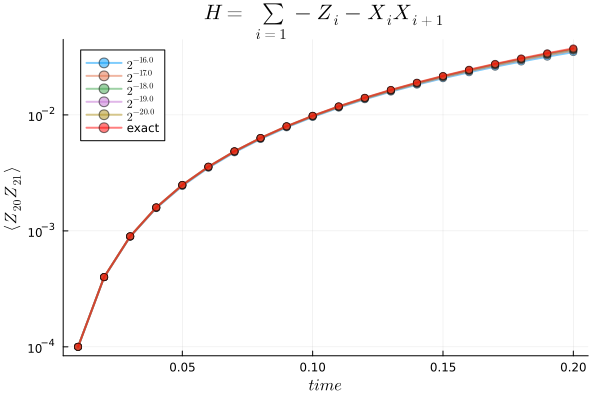

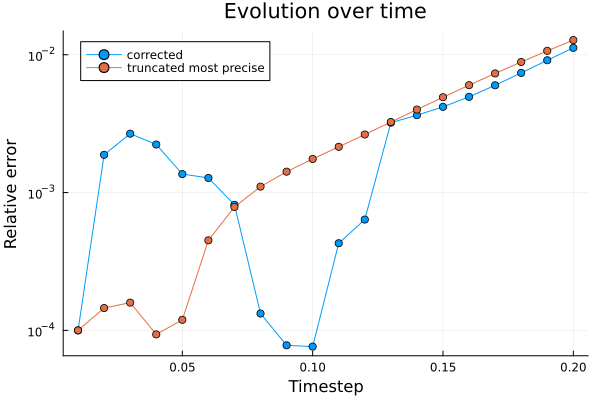

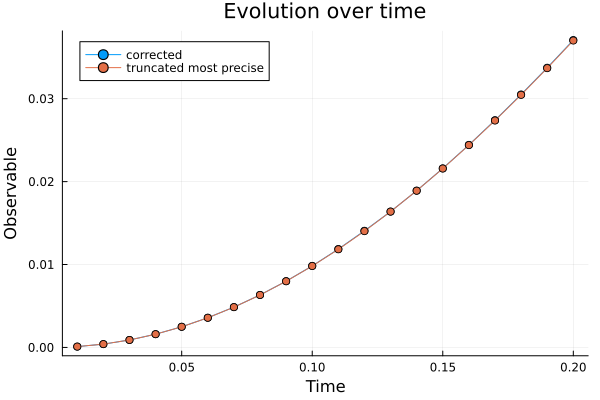

In [12]:
model = "TFIM"

theta = 0.01im
θ = theta
nq = 30
nl = 20

topology = bricklayertopology(nq)

# the circuit
circuitTFIM = Gate[]
for i in 1:nl
    #append!(circuitTFIM, PauliRotation(:X, ii, θ) for ii in 1:nq);
    append!(circuitTFIM, PauliRotation(:Z, ii, θ) for ii in 1:nq);
    append!(circuitTFIM, PauliRotation([:X, :X], pair, θ) for pair in topology);
end

# system parameters
obs_i = 21
obs_j = 20
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])

# max_weight = 9
max_weight = 6
trunc_coeffs = 2.0 .^ (-16:-1:-20)

tstep = 0.01
time = range(tstep, tstep*nl, nl)

fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}", model, nq, nl, tstep, obs_i, obs_j, max_weight)    

# initialize the plot
scatter(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"time", title = L"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$")

# exact expectation values calculations
M = jordan_wigner_tfim(nq, 1.0, 0.0, 1.0)
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], obs_i, obs_j)
end

# get truncated expectation values
expvals = Vector{Vector{Float64}}()
for j in trunc_coeffs
    expectation = run_or_read("TFIM", circuitTFIM, nq, nl, tstep, obs_i, obs_j, max_weight, j)
    plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
end
plot!(yscale=:log10)
plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)


display(scatter!())
zte_exp(expvals, trunc_coeffs, time; exact_expvals=zz, fn=fn);

Then we tried by performing different weight truncations.

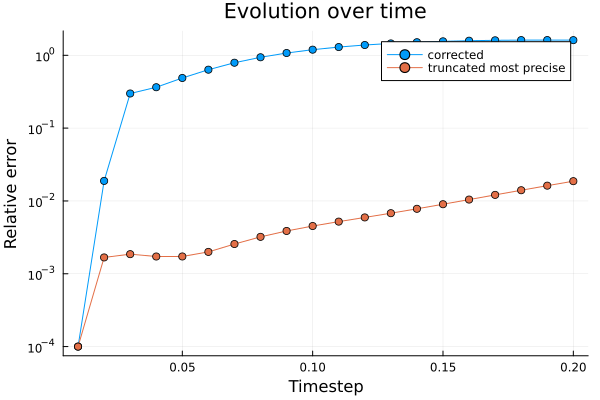

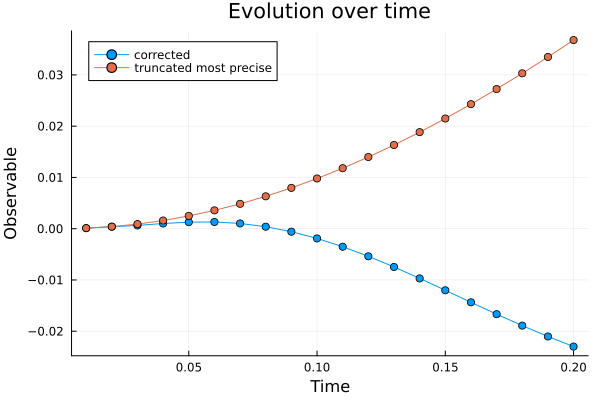

In [13]:
model = "TFIM"

theta = 0.01im
θ = theta
nq = 30
nl = 20

topology = bricklayertopology(nq)

# the circuit
circuitTFIM = Gate[]
for i in 1:nl
    #append!(circuitTFIM, PauliRotation(:X, ii, θ) for ii in 1:nq);
    append!(circuitTFIM, PauliRotation(:Z, ii, θ) for ii in 1:nq);
    append!(circuitTFIM, PauliRotation([:X, :X], pair, θ) for pair in topology);
end

observable = PauliString(nq, [:Z,:Z], [20,21])
nl = 20
nq = 30
weights = 2:1:6
min_abs_coeff = 2^(-19)
time = range(0.01, 0.01*nl, nl)

# plot(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel="t", title = L"$H = \sum_{i=1} X_i - Z_iZ_{i+1}$")

fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_minabscoeff={:.4e}", model, nq, nl, tstep, obs_i, obs_j, min_abs_coeff)    

# plot(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$")

M = jordan_wigner_tfim(nq, 1.0, 0.0, 1.0)
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], 20, 21)
end

expvals = Vector{Vector{Float64}}()
for j in weights
    expectation = run_or_read("TFIM", circuitTFIM, nq, nl, tstep, obs_i, obs_j, j, min_abs_coeff)
    error = abs.(expectation-zz)
    # plot!(time, error, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    
    # plot!(time, expectation, label = j, legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
end
# plot!(yscale=:log10)
# plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)

# display(plot!())

zte_exp(expvals, weights, time; exact_expvals=zz, fn=fn);


Weight truncation is definitely bad.

## XY model
Same concept on XY model.

Starting by varying min_abs_coeff.

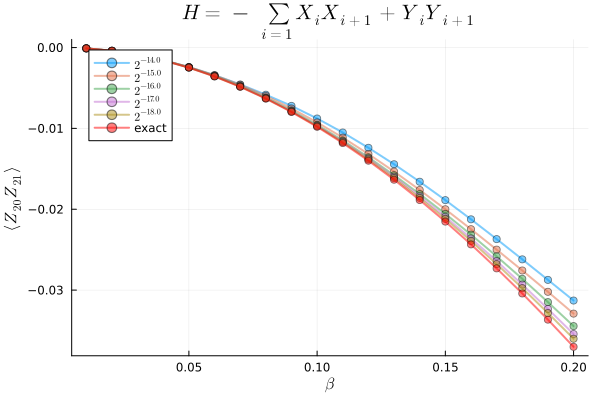

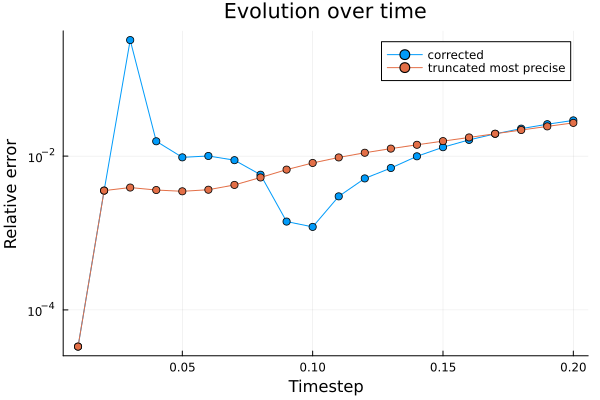

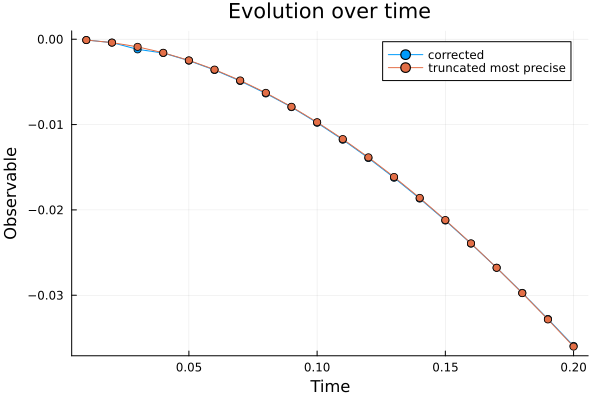

In [14]:
model = "XY"

theta = 0.01im
θ = theta
nq = 30

topology = bricklayertopology(nq)

# the circuit
circuitXY = Gate[]
nl = 20
for i in 1:nl
    append!(circuitXY, PauliRotation([:X, :X], pair, θ) for pair in topology);
    append!(circuitXY, PauliRotation([:Y, :Y], pair, θ) for pair in topology);
end

obs_i = 21
obs_j = 20
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])

# nl = 20
trunc_coeffs = 2.0 .^ (-14:-1:-18)
max_weight = 9
time = range(0.01, 0.01*nl, nl)


fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}", model, nq, nl, tstep, obs_i, obs_j, max_weight)    

plot(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"\beta", title = L"$H = - \sum_{i=1}  X_iX_{i+1} + Y_iY_{i+1}$")

M = jordan_wigner_tfim(nq, 1.0, 1.0, 0.0)
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], obs_i, obs_j)
end

expvals = Vector{Vector{Float64}}()
for j in trunc_coeffs
    expectation = run_or_read("XY", circuitXY, nq, nl, tstep, obs_i, obs_j, max_weight, j; run=false)
    error = abs.(expectation-zz)
    # plot!(time, error, label = j, legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
end

plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
# plot!(yscale=:log10)

display(plot!())

zte_exp(expvals, trunc_coeffs, time; exact_expvals=zz, fn=fn);

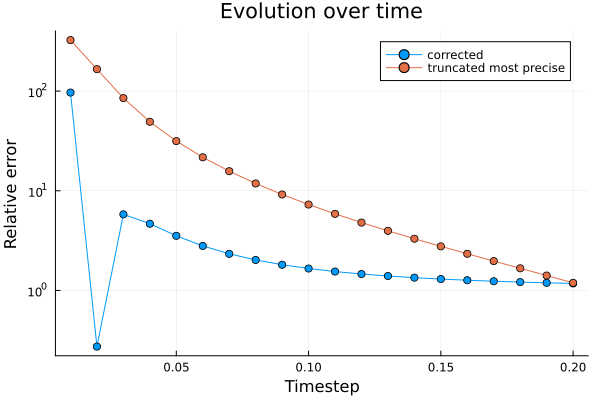

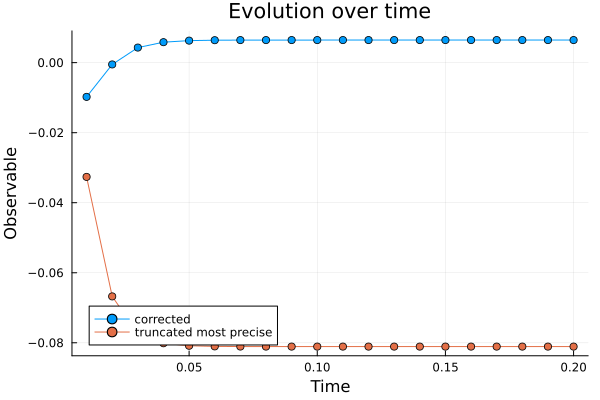

In [15]:
model = "XY"

theta = 0.01im
θ = theta
nq = 30

topology = bricklayertopology(nq)

# the circuit
circuitXY = Gate[]
nl = 20
for i in 1:nl
    append!(circuitXY, PauliRotation([:X, :X], pair, θ) for pair in topology);
    append!(circuitXY, PauliRotation([:Y, :Y], pair, θ) for pair in topology);
end

obs_i = 21
obs_j = 20
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])

# nl = 20
weights = 2:1:5
min_abs_coeff = 2^(-19)
time = range(0.01, 0.01*nl, nl)


fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}", model, nq, nl, tstep, obs_i, obs_j, max_weight)    

# plot(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"\beta", title = L"$H = - \sum_{i=1}  X_iX_{i+1} + Y_iY_{i+1}$")

M = jordan_wigner_tfim(nq, 1.0, 1.0, 0.0)
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], obs_i, obs_j)
end

expvals = Vector{Vector{Float64}}()
for j in weights
    expectation = run_or_read("XY", circuitXY, nq, nl, tstep, obs_i, obs_j, j, min_abs_coeff; run=false)
    error = abs.(expectation-zz)
    # plot!(time, error, label = j, legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    # plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
end

# plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
# plot!(yscale=:log10)

# display(plot!())

zte_exp(expvals, weights, time; exact_expvals=zz, fn=fn);

I don't know what happened here, but it's really weird. In any case the correction is completely wrong.

## Heisenberg Model
For this model, we don't have exact solution (but could compute it up to 30 qubits in theory).


Varying min_abs_coeff first.

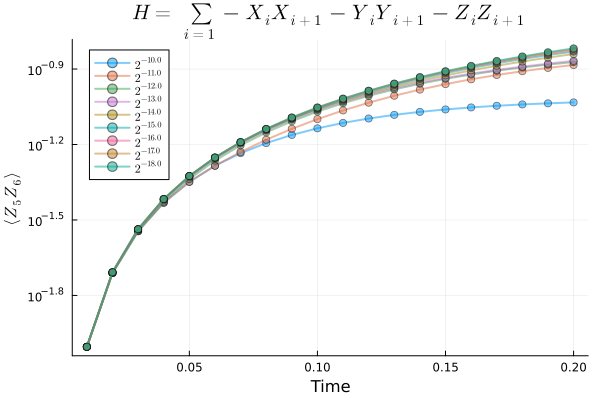

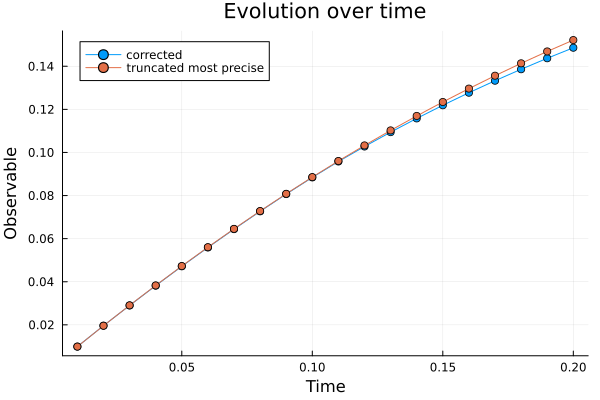

In [18]:
theta = 0.01im
θ = theta
nq = 30

topology = bricklayertopology(nq)

# the circuit
circuitH = Gate[]
nl = 20
for i in 1:nl
    append!(circuitH, PauliRotation([:X, :X], pair, θ) for pair in topology);
    append!(circuitH, PauliRotation([:Y, :Y], pair, θ) for pair in topology);
    append!(circuitH, PauliRotation([:Z, :Z], pair, θ) for pair in topology);

end


obs_i = 5
obs_j = 6
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])
time = range(0.01, 0.01*nl, nl)
trunc_coeffs = 2.0 .^ (-10:-1:-18)
max_weight = 9


fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:.4e}", model, nq, nl, tstep, obs_i, obs_j, max_weight)    

# approximateExpectations = []
# for i in time
#     expectation = (-i-(i^2))/(1+3/2*i^2*(nq-1))
#     push!(approximateExpectations, expectation)
# end

plot(ylabel=L"$\langle Z_{5}Z_{6} \rangle$", xlabel="Time", title = L"$H = \sum_{i=1} - X_iX_{i+1} - Y_iY_{i+1} - Z_iZ_{i+1}$")

expvals = Vector{Vector{Float64}}()
for j in trunc_coeffs
    expectation = run_or_read(model, circuitH, nq, nl, tstep, obs_i, obs_j, max_weight, j)
    # error = abs.(expectation - approximateExpectations)
    # plot!(time, error, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
end

plot!(yscale=:log10)

display(plot!())

zte_exp(expvals, trunc_coeffs, time; fn=fn);

Varying the weight.

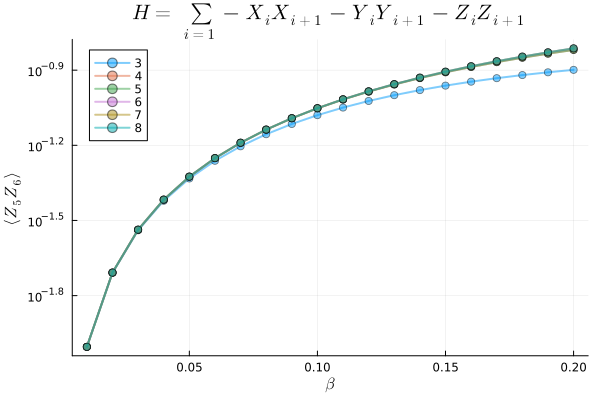

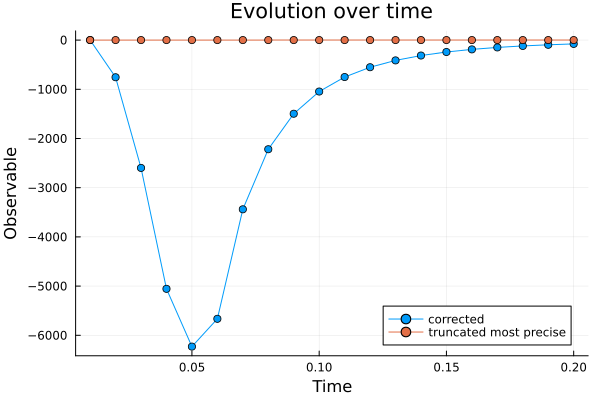

In [19]:
model = "Heisenberg"

theta = 0.01im
θ = theta
nq = 12

topology = bricklayertopology(nq)

# the circuit
circuitH = Gate[]
nl = 20
for i in 1:nl
    append!(circuitH, PauliRotation([:X, :X], pair, θ) for pair in topology);
    append!(circuitH, PauliRotation([:Y, :Y], pair, θ) for pair in topology);
    append!(circuitH, PauliRotation([:Z, :Z], pair, θ) for pair in topology);

end

obs_i = 5
obs_j = 6
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])
tstep = 0.01
time = range(tstep, tstep*nl, nl)
weights = 3:1:8
min_abs_coeff=2^(-21)

fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_minabscoeff={:.4e}", model, nq, nl, tstep, obs_i, obs_j, min_abs_coeff)    

plot(ylabel=L"$\langle Z_{5}Z_{6} \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} - X_iX_{i+1} - Y_iY_{i+1} -Z_iZ_{i+1}$")


expvals = Vector{Vector{Float64}}()
for j in weights
    expectation = run_or_read(model, circuitH, nq, nl, tstep, obs_i, obs_j, j, min_abs_coeff)
    plot!(time, expectation, label = j, legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
end
plot!(yscale=:log10)
# plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)

display(plot!())
zte_exp(expvals, weights, time; fn=fn);

We should stop the massacre, ZTE varying weight truncation definitely doesn't work.